In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment1/AIP2023-Assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

from pandas.core.common import flatten
import copy
import numpy as np
import random

from PIL import Image

import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

from sklearn.neighbors import KNeighborsClassifier
import glob
from tqdm import tqdm
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import classification_report

from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

In [ ]:
##Class for custom dataset
class ClassificationDataset(torch.utils.data.Dataset):
  
  def __init__(self, root, mode, transforms=None):
    data_paths = root + mode
    image_paths = [] #to store image paths in list
    classes = [] #to store class values

    for data_path in glob.glob(data_paths + '/*'):
      classes.append(data_path.split('/')[-1])
      image_paths.append(glob.glob(data_path + '/*'))
    
    classes = sorted(classes)
    self.classes = classes
    self.class_to_labels = {j:i for i,j in enumerate(classes)}
    self.labels_to_class = {i:j for i,j in enumerate(classes)}

    image_paths = list(flatten(image_paths))
    random.shuffle(image_paths)
    self.image_paths = image_paths

    self.transforms = transforms
    self.mode = mode
        
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    image = Image.open(image_filepath).convert('RGB')
    label = torch.tensor(self.class_to_labels[image_filepath.split('/')[-2]])

    if self.transforms is not None:
      image = self.transforms[self.mode](image)

    return image, label

In [ ]:
##Data transforms that are applied to train, test and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
##Code for data preparation and loading
data_dir = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME)
image_datasets = {x: ClassificationDataset(data_dir, x, data_transforms)
                          for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=2)
              for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##Class for define model
class ResNet18FeatureExtractor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model_conv = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)
    for param in model_conv.parameters():
      param.requires_grad = False
    return_nodes = {
      'flatten' : 'layer1'
    }
    self.body = create_feature_extractor(model_conv, return_nodes = return_nodes)

  def forward(self, x):
      x = self.body(x)
      return x

In [ ]:
##Model Initialiaztion
model = ResNet18FeatureExtractor()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
##Code to extract train feature vectors
train_feature_vectors = []
train_label_vectors = []
model.to(device)
model.eval()

for inputs, labels in dataloaders['train']:
  inputs = inputs.to(device)
  features = model(inputs)
  train_feature_vectors.append(features['layer1'].cpu().detach().numpy())
  train_label_vectors.append(labels.numpy())


In [ ]:
##Code to extract test feature vectors
test_feature_vectors = []
test_label_vectors = []
model.to(device)
for inputs, labels in dataloaders['test']:
  inputs = inputs.to(device)
  features = model(inputs)
  test_feature_vectors.append(features['layer1'].cpu().detach().numpy())
  test_label_vectors.append(labels.numpy())


In [ ]:
train_label_vectors = np.array(train_label_vectors).reshape(133*4,)
train_feature_vectors = np.array(train_feature_vectors).reshape((133*4, 512))

test_label_vectors = np.array(test_label_vectors).reshape(120,)
test_feature_vectors = np.array(test_feature_vectors).reshape((120, 512))

In [ ]:
##Function to get KNN accuracy
def getKNNaccuracy(train_feature_vectors, train_label_vectors, test_feature_vectors, test_label_vectors, k):
  knn_classifier = KNeighborsClassifier(n_neighbors = k)
  knn_classifier.fit(train_feature_vectors, train_label_vectors) 
  preds = knn_classifier.predict(test_feature_vectors)
  count = 0
  for i in range(len(test_label_vectors)):
    if test_label_vectors[i] == preds[i]:
      count = count + 1
  acc = count * 100 /len(test_label_vectors)
  return preds, acc

In [ ]:
##Function to plot accuracy vs k
def plot_graph_k_test_acc():
  num_neighbours = []
  test_accuracy = []
  for k in range(1,532):
    num_neighbours.append(k)
    _, acc = getKNNaccuracy(train_feature_vectors, train_label_vectors, test_feature_vectors, test_label_vectors, k)
    test_accuracy.append(acc)
  plt.figure(figsize=(8,6), dpi=100)
  plt.scatter(num_neighbours, test_accuracy)
  plt.xlabel("k")
  plt.ylabel("test accuracy")
  plt.title('test_accuracy vs k' )

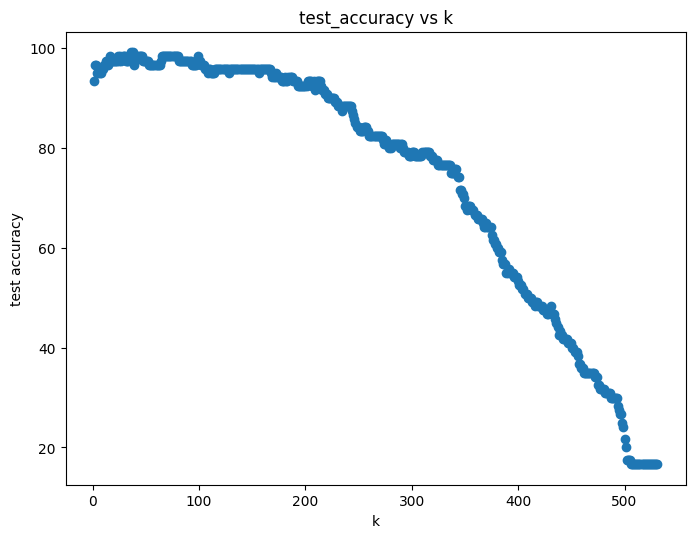

In [ ]:
plot_graph_k_test_acc()

In [ ]:
##Code to get accuracy for k =40
_, acc = getKNNaccuracy(train_feature_vectors, train_label_vectors, test_feature_vectors, test_label_vectors, 40)
print('Accuracy for k = 40 is {}'.format(acc))

Accuracy for k = 40 is 97.5


In [ ]:
##Function to get classification report
def getClassificationReport(train_feature_vectors, train_label_vectors, test_feature_vectors, test_label_vectors, k):
  preds, acc = getKNNaccuracy(train_feature_vectors, train_label_vectors, test_feature_vectors, test_label_vectors, k)
  report = classification_report(test_label_vectors, preds, target_names=class_names)
  return report

In [ ]:
report = getClassificationReport(train_feature_vectors, train_label_vectors, test_feature_vectors, test_label_vectors, 10)
print(report)

              precision    recall  f1-score   support

        bear       1.00      0.85      0.92        20
   butterfly       1.00      1.00      1.00        20
       camel       1.00      0.90      0.95        20
       chimp       0.87      1.00      0.93        20
        duck       1.00      1.00      1.00        20
    elephant       0.91      1.00      0.95        20

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



In [ ]:
def plt_decision_regions(train_feature_vectors, train_label_vectors, k = 10):

  ##used PCA to reduce the dimension of the feature vectors to 2
  reduced_dimensional_features = PCA(2).fit_transform(train_feature_vectors)

  knn_classifier = KNeighborsClassifier(n_neighbors = 10)
  knn_classifier.fit(reduced_dimensional_features, train_label_vectors) 

  #plotting

  fig = plt.figure(figsize=(8, 8))
  plot_decision_regions(reduced_dimensional_features,train_label_vectors, clf = knn_classifier, legend=2)
  plt.xlabel('feature dim 1')
  plt.ylabel('feature dim 2')
  plt.title('Decision regions for kNN')
  plt.show()

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


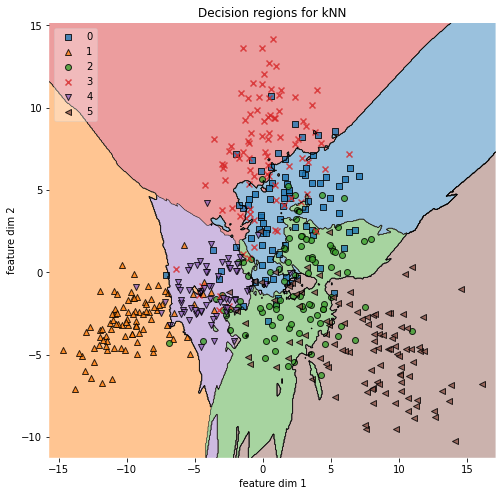

In [ ]:
plt_decision_regions(train_feature_vectors, train_label_vectors)